-> generation de e_in avec une séquence qui se répète 

-> génération de e_in avec une séquence qui se répète avec du bruit 

-> STDP entre e_in et e_out pour apprendre les poids 

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

INFO       Cache size for target "cython": 2146 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\camil\.cython\brian_extensions" directory. [brian2]


In [2]:
Ni = 1 #nb de PGs différents
Nj = 10 #nb d'adresses en entrée 
n_pattern = 30 # nb d'occurrence des PGs 
duration = 10*second

In [3]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []
nn_j = []
W = []
n_j_quick =[]

kappa = 1.5
for k in range(Ni) : 
    n_j = (np.random.randint(3, Nj, size = 1)) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    #W.append(list(np.random.rand(int(n_j))))
    W.append(list(np.exp(kappa*np.cos(2*np.pi * (np.linspace(0, 1, int(n_j), endpoint=True) - k/Ni )))))
    W[k] /= sum(W[k])
    i_syn_bruit = np.linspace
n_syn = sum(n_syn) 


# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 

#### quick

In [4]:
def quick_generator(Ni, Nj, n_pattern, i_indices, i_temps, i_syn, W, delay, sigma):
    start_scope()
    start = time.time()
    
    a = SpikeGeneratorGroup(Ni, i_indices, i_temps)
    a_spike = SpikeMonitor(a)
    
    b = NeuronGroup(Nj, ''' dv/dt = -v/tau + sigma*sqrt(2/tau)*xi  : volt
                                tau : second''',
                       threshold= 'v > 0.02000*volt',
                        reset= 'v = 0*volt',
                        method = 'euler')
#+ sigma*sqrt(2/tau)*xi 
    b.v = 0*volt
    b.tau = 0.01*second

    b_spike = SpikeMonitor(b)
        #b_state = StateMonitor(b, 'v', record = True)

    s = Synapses(a,b, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        s.connect(i = k , j = i_syn[k])
        s.w[k,:] = W[k]*20 
            
    s.delay[:,:] = delay
    
    # --- generation de e_true/detectorrr_terminator ----------------------------------------------------------------------------------
    
    
    c =  NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.005*volt',
                        reset= 'v = 0*volt', 
                        method = 'exact')
    
    c.v = 0*volt
    c.tau = 0.1*second
    c_spike = SpikeMonitor(c)
    
    syn = Synapses(b,c, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        syn.connect(i = i_syn[k], j = k)         
        syn.w[:,k] = W[k]
        syn.delay[:,k] = max(s.delay[k,:])-s.delay[k,:]
    
    
    net_quick = Network(collect())
    net_quick.add(a, a_spike, b, b_spike, c, c_spike, s, syn)
    net_quick.run(duration)
    
    e_in_ = (b_spike.t, b_spike.i)
    e_true_ = (c_spike.t, c_spike.i) #plutot a_spike ? 
    
    e_in=[]
    e_true=[]
    
    for i in range(len(e_in_[0])):
        e_in.append(tuple((e_in_[0][i]*1000/second, e_in_[1][i])))
    
    for i in range(len(e_true_[0])):
        e_true.append(tuple((e_true_[0][i]*1000/second, e_true_[1][i])))
        
    print('generation time: ', time.time() - start)
    
    return s, syn, a_spike, b_spike, c_spike, e_in, e_true
        

In [5]:
sigma = 8.3*mV
s, syn, a_spike, b_spike, c_spike, e_in, e_true = quick_generator(Ni, Nj, n_pattern, i_indices, i_temps, i_syn, W, delay, sigma)

generation time:  12.285485982894897


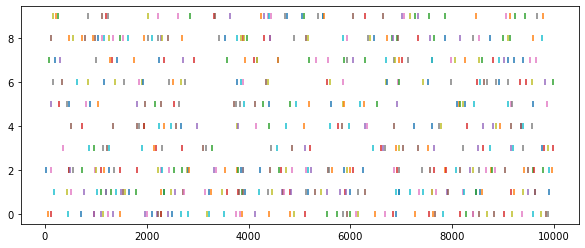

In [6]:
plt.figure(figsize=(10,4))
for i in range(len(e_in)):
    plt.scatter(e_in[i][0], e_in[i][1],marker ='|')

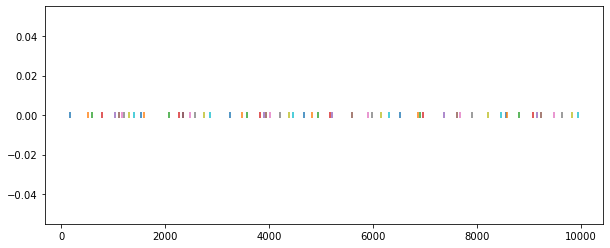

In [7]:
plt.figure(figsize=(10,4))
for i in range(len(e_true)):
    plt.scatter(e_true[i][0], e_true[i][1],marker ='|')

#### each

In [8]:
def i_want_to_see_each_sequence (Ni, duration, W, delay, i_syn) : 
    
    start_scope()
    start = time.time()
    
    
    x = SpikeGeneratorGroup(Ni, linspace(0,Ni-1, num = Ni, dtype = int), linspace(0,Ni-1, num = Ni, dtype = int)*second)
    x_s = SpikeMonitor(x)
        
    y = NeuronGroup(Nj, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.02*volt',
                        reset= 'v = 0*volt', 
                        method = 'exact')
    y_s = SpikeMonitor(y)
    
    y.v = 0*volt
    y.tau = 0.01*second
    
    z = Synapses(x,y, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        z.connect(i = k , j = i_syn[k])
        z.w[k,:] = W[k]*20 
             
    z.delay[:,:] = delay        
    
    net_see_seq = Network(collect())
    net_see_seq.add(x, x_s, y, y_s, z)
    net_see_seq.run(3*second)
    
    plt.figure(figsize =(10,4))
    plt.scatter(x_s.t, x_s.i, marker = '|')
    
    plt.figure(figsize =(10,4))
    plt.scatter(y_s.t, y_s.i, marker = '|')
    print('each seq time :', time.time() - start )
    return x_s, y_s, z

each seq time : 2.3642923831939697


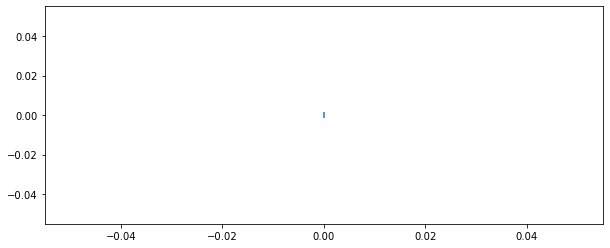

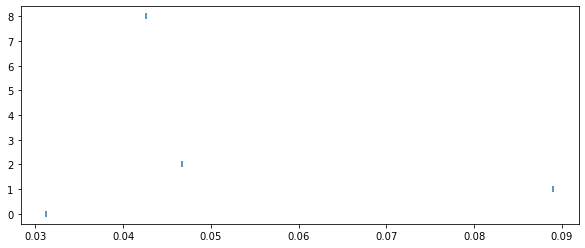

In [9]:
x_s, y_s, z = i_want_to_see_each_sequence (Ni, duration, W, delay, i_syn) 

In [10]:
W

[array([0.27994549, 0.15914721, 0.04473756, 0.01616974, 0.01616974,
        0.04473756, 0.15914721, 0.27994549])]

#### STDP

In [11]:
def STDP_with_r(e_in, e_out, e_true, N_epoch):
    
    start = time.time()

    e_true_safe= [ele for ele in e_true if ele != []]
    
    tau_pre = tau_post = 100*ms #même tau pour w_stdp et w_r ? 
    A_pre = 1
    A_post = -A_pre*1.05
    
# === règle homeostasique =====================================================================================================================

    len_e_true = {}
    len_e_out = {}
    w_homéo = {}
    
    for i in range(Ni):
        len_e_true[i] = []
        len_e_out[i] = []
        w_homéo[i] = []
        for k in e_true_safe :
            if k[1]==i : 
                len_e_true[i].append(k[1])
        for k in e_out:
            if k[1]==i : 
                len_e_out[i].append(k[1])
        if len(len_e_true[i])>len(len_e_out[i]) :
            w_homéo[i] = 0.1
        if len(len_e_true[i])<len(len_e_out[i]) :
            w_homéo[i] = -0.1
        if len(len_e_true[i])==len(len_e_out[i]) :
            w_homéo[i] = 0 
            
    print('w_homéo :', w_homéo)    
        
            
# === STDP entre e_in et e_out =================================================================================================================
    
    # --- delta_T entre chaque paire de spike -------------------------------------------------------------------------------------------------
    
    delta_T_STDP = []
    comparaison_STDP = []
    
    for k in range(len(e_out)):
        for i in range(len(e_in)):
            delta_T_STDP.append(e_out[k][0]*ms - e_in[i][0]*ms) #on prend le premier spike de e_out et on le compare avec tous les spikes de e_in (Ni,Nj)
            comparaison_STDP.append(tuple((e_out[k][1], e_in[i][1]))) 
    print('len(delta_T_STDP) :', len(delta_T_STDP))
    # --- def des w_STDP à partir des delta_T e_in/e_out ----------------------------------------------------------------------------------------------------
    
    w_STDP = []        
    for i in range(len(delta_T_STDP)):         
        w_STDP.append(where(delta_T_STDP[i]>0, A_pre*exp(-delta_T_STDP[i]/tau_pre), A_post*exp(delta_T_STDP[i]/tau_post))) #on définit des w pour tous les delta_T, ils sont rangés dans l'ordre e_out_1, e_in_all, e_out_2, e_in_all
    
    # --- visu w_STDP -----------------------------------------------------------------------------------------------------------------------------------
   
    if N_epoch == 0 : 
        plt.figure(figsize=(10,4))
        plt.scatter(delta_T_STDP/ms, w_STDP)
        xlabel(r'$\Delta t$ (ms)')
        ylabel('W')
        axhline(0, ls='-', c='k')
        title (' w_STDP ')
    
# === Def de la variable R e_out/e_true =================================================================================================================
    
    # --- delta_T entre paire de spike du même indice -------------------------------------------------------------------------------------------
    
    delta_T_r = {}
    delta_T_r_plot = []
    for k in range(len(e_out)) :
        delta_T_r[k] = []
        for i in e_true_safe : 
            if i[1] == e_out[k][1] :
                delta_T_r[k].append(i[0]*ms-e_out[k][0]*ms)
                delta_T_r_plot.append(i[0]*ms-e_out[k][0]*ms)
    print('len(delta_T_r) : ', len(delta_T_r))

    # --- def de R à partir des delta_T e_out/e_true ----------------------------------------------------------------------------------------------------------
    
    w_r = {}
    w_r_plot = []
    for i in range(len(delta_T_r)) : 
        w_r[i] = []
        for k in range(len(delta_T_r[i])) : 
            w_r[i].append(where(delta_T_r[i][k]>0, delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_pre)), delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_post)))/second)  
        w_r[i] = sum(w_r[i])   
        
    # --- visu r ----------------------------------------------------------------------------------------------------------------------------------------------------
    
    if N_epoch == 0 : 
        plt.figure(figsize=(10,4))
        plt.scatter(delta_T_r_plot/ms, w_r_plot)
        xlabel(r'$\Delta t$ (ms)')
        ylabel('W')
        axhline(0, ls='-', c='k')
        title ('variable R')
    
    
# === Def des delta_w de chaque synapse par w_homéo*R*w_STDP =================================================================================================================
    
    w_STDP_r = {}
    for i in range(len(e_out)):
        w_STDP_r[i] = []
        for k in range(i*len(e_in),(i+1)*len(e_in)) : 
            w_STDP_r[i].append(tuple((w_STDP[k]*w_r[i], comparaison_STDP[k])))
    
    w_syn = {}  
    w_syn_mean = {}
    w_syn_= {}
    for k in range(Nj):
        for c in range(1):
            w_syn[k,c] = []
            
    for a in range(len(e_out)):        
        for i in w_STDP_r[a] :
            for k in range(Nj): 
                for c in range(Ni): 
                    if i[1]==(c,k):
                        w_syn[k,c].append(i[0])
                    w_syn_mean[k,c] = sum(w_syn[k,c]) #somme 
                    
    w_STDP_r_homéo = {}
    
    for k in w_homéo : 
        for i in w_syn_mean : 
            if k==i[1] :
                    w_STDP_r_homéo[i[0],k] = (w_syn_mean[i])+w_homéo[k]
                
    print('w_STDP_r_homéo :', len(w_STDP_r_homéo), 'w_STDP_r_homéo[0]', w_STDP_r_homéo[0,0])
    w_per_synapse_list = []
    for k in range(Nj):
        for c in range(Ni):
                w_per_synapse_list.append(w_STDP_r_homéo[k,c]) ## pour changer la grandeur, changer Apre/apost et faire la somme plutot que la 
                
    w_per_synapse_list = np.nan_to_num(w_per_synapse_list, -.1*10e-50)
    print('w_per_synapse_list', w_per_synapse_list)
    
    print('W_STDP_r_homéo time : ', time.time() - start)

    return w_per_synapse_list

#### NN

In [12]:
def neural_network_2(e_in, w_per_synapse_list, N_epoch):
    start_scope()
    
    start = time.time()
    
    PGs_learning = {}
    ind_in = []
    temps_in = []
    
    random_size = np.random.randint(0,60)
    ind_out = np.random.randint(0, 1, size = random_size) # nombre de PG observé (n_pattern), de Ni sortes différentes
    temps_out = np.random.uniform(0, duration, size = random_size)*second

 
    thresh = 0.02*volt # /!\

    # --- generation du NN -------------------------------------------------------------------------------------------
    e_in_safe = [] 
    for i in e_in:
        if i not in e_in_safe:
            e_in_safe.append(i)
        
    for i in range(len(e_in_safe)): 
        temps_in.append((e_in_safe[i][0])*msecond)
        ind_in.append(e_in_safe[i][1])
    
    if N_epoch == 0 : 
        
        print('ind_out : ',ind_out)
        print('temps_out : ', temps_out)
        e = SpikeGeneratorGroup(Ni, ind_out, temps_out)
        e_spike = SpikeMonitor(e)
        
        run(duration)
        
        PGs_learning = (e_spike.t, e_spike.i)
        e_out = []
    
        for i in range(len(PGs_learning[0])):
            e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
        print('NN time - epoch 0 : ', time.time() - start)

        return e_out, e_spike
        
    else : 
        
        d = SpikeGeneratorGroup(Nj, ind_in, temps_in)
        d_spike = SpikeMonitor(d)

        e = NeuronGroup(1, ''' dv/dt = -v/tau : volt
                    tau : second''',
                    threshold= 'v > 0.0200*volt',
                    reset= 'v = 0*volt',
                    method = 'exact')
        e.v = 0*volt
        e.tau = 0.001*second
        e_spike = SpikeMonitor(e)
    
        naps = Synapses(d, e, on_pre = '''v_post += 0.01*w*volt''', model = '''w:1''')

        naps.connect(p=1)
 
        naps.w[:,:] = w_per_synapse_list
   
        run(duration)
    
        PGs_learning = (e_spike.t, e_spike.i)
        e_out = []
    
        for i in range(len(PGs_learning[0])):
            e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
        print('NN time : ', time.time() - start)

        return e_out, naps, e_spike

#### learn

In [13]:
def learn_weight_2 (Ni, n_pattern, duration, nn_j, i_syn):
    
    N_epoch = 20
    
    delta_e_in = []
    delta_e_true = []
    delta_w = []
    delta_e_out = []
    naps_w = []
    
    start = time.time()

    
    for N_epoch in range(N_epoch): 
        
        i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
        i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 
        
        s, syn, a_spike, b_spike, c_spike, e_in, e_true = quick_generator(Ni, Nj, n_pattern, i_indices, i_temps, i_syn, W, delay, sigma)      
        delta_e_in.append(e_in) 
        delta_e_true.append(e_true)
            
        if N_epoch == 0 :
            e_out, e_spike = neural_network_2(delta_e_in[N_epoch], 0, N_epoch)
            delta_e_out.append(e_out)
            
        if N_epoch == 1 : 
            w_per_synapse_list  = STDP_with_r (delta_e_in[N_epoch-1], delta_e_out[N_epoch-1],delta_e_true[N_epoch-1], N_epoch)
            delta_w.append( w_per_synapse_list)
            print('w_per_synapse_list',w_per_synapse_list)
            
            e_out, naps, e_spike = neural_network_2(delta_e_in[N_epoch], np.random.randint(-10,10, Ni*Nj)+delta_w[N_epoch-1], N_epoch)
            print('naps', naps.w) 
            naps_w.append(naps.w)
            delta_e_out.append(e_out)
            
        if N_epoch > 1 :  
            w_per_synapse_list  = STDP_with_r (delta_e_in[N_epoch-1], delta_e_out[N_epoch-1],delta_e_true[N_epoch-1], N_epoch)
            delta_w.append( w_per_synapse_list)
            print('w_per_synapse_list',w_per_synapse_list)
            
            e_out, naps, e_spike = neural_network_2(delta_e_in[N_epoch], naps_w[N_epoch-2]+delta_w[N_epoch-1] , N_epoch)
            print('naps', naps.w) 
            naps_w.append(naps.w)
            delta_e_out.append(e_out)
            
        
         
        print('N_EPOCH :', N_epoch)
    print('TIMETOT', time.time() - start)
    return delta_e_out, delta_e_true, delta_e_in, delta_w, naps_w, naps

In [14]:
 delta_e_out, delta_e_true, delta_e_in, delta_w, naps_w, naps = learn_weight_2 (Ni, n_pattern, duration, nn_j, i_syn)

generation time:  11.06319808959961
ind_out :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
temps_out :  [0.08367668 1.11379432 1.53452946 4.4102243  9.16200307 7.0435374
 7.24141928 4.21011197 4.02995633 3.16736915 0.24849125 1.52732107
 6.05961041 6.46123086 0.26707712 9.4853372  4.60130271 8.08444991
 5.10623028 9.03292151 1.42005403 4.39885518 9.82644501 2.92677222
 3.67396385 3.91501621 3.88602701 1.92951724 0.68600977 4.89376502
 3.8358606  4.14690193 2.00629949 0.426736   3.88284324 2.08529698
 4.68249747 8.26810623 9.55287951 1.28627029 4.22241445 9.59934565
 7.09383409 3.23945108 6.83897769 1.4393437  2.54907726 0.88790202
 8.64630712 8.2256652  2.27828451 9.90240299 1.25957021 8.12971327
 2.52246849] s
NN time - epoch 0 :  2.6342387199401855
N_EPOCH : 0
generation time:  11.051430225372314
w_homéo : {0: 0.1}
len(delta_T_STDP) : 27390
len(delta_T_r) :  55
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] -0.44895379753677

In [55]:
#signal/bruit 
len(y_s.t)*n_pattern / (len(delta_e_in[19])-len(y_s.t)*n_pattern)

0.32

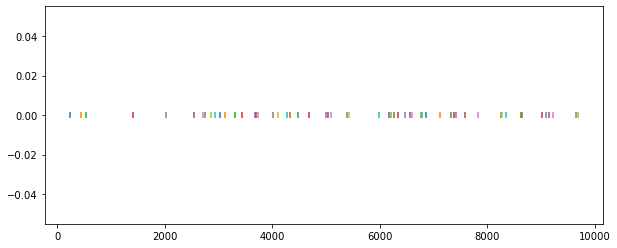

In [20]:
plt.figure(figsize=(10,4))
for i in range(len(delta_e_out[19])):
    plt.scatter(delta_e_out[19][i][0], delta_e_out[19][i][1], marker = '|')

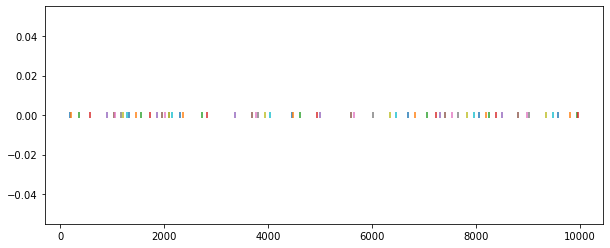

In [56]:
plt.figure(figsize=(10,4))
for i in range(len(delta_e_true[19])):
    plt.scatter(delta_e_true[19][i][0], delta_e_true[19][i][1], marker = '|')

In [64]:
len(s.j), len(W[0])

(8, 8)

In [63]:
Ni*Nj, len(naps_w[18])

(10, 10)

In [80]:
s.w[0,:]

array([5.59890978, 3.18294414, 0.89475128, 0.3233948 , 0.3233948 ,
       0.89475128, 3.18294414, 5.59890978])

In [81]:
for i in s.j : 
    print(i,0, s.w[0,i])

1 0 [5.59890978]
2 0 [3.18294414]
5 0 [0.89475128]
3 0 [0.3233948]
9 0 [0.3233948]
7 0 [0.89475128]
0 0 [3.18294414]
8 0 [5.59890978]


In [75]:
for i in s.j : 
    print(i, 0, naps.w[i,0])

1 0 [-42.61412465]
2 0 [-33.76137012]
5 0 [-14.96327039]
3 0 [-7.35336266]
9 0 [-8.94745263]
7 0 [-1.13299022]
0 0 [-15.05140026]
8 0 [-41.42243341]


In [73]:
delta_e_out[19], delta_e_true[19]

([(246, 0),
  (440, 0),
  (534, 0),
  (1405, 0),
  (2025, 0),
  (2547, 0),
  (2712, 0),
  (2742, 0),
  (2860, 0),
  (2939, 0),
  (3026, 0),
  (3117, 0),
  (3303, 0),
  (3446, 0),
  (3680, 0),
  (3703, 0),
  (3736, 0),
  (4011, 0),
  (4112, 0),
  (4281, 0),
  (4322, 0),
  (4325, 0),
  (4484, 0),
  (4687, 0),
  (5004, 0),
  (5031, 0),
  (5098, 0),
  (5383, 0),
  (5424, 0),
  (5989, 0),
  (6163, 0),
  (6203, 0),
  (6268, 0),
  (6337, 0),
  (6477, 0),
  (6556, 0),
  (6602, 0),
  (6759, 0),
  (6766, 0),
  (6777, 0),
  (6868, 0),
  (7119, 0),
  (7332, 0),
  (7377, 0),
  (7420, 0),
  (7586, 0),
  (7833, 0),
  (8260, 0),
  (8277, 0),
  (8340, 0),
  (8632, 0),
  (8632, 0),
  (8641, 0),
  (9024, 0),
  (9099, 0),
  (9150, 0),
  (9223, 0),
  (9647, 0),
  (9679, 0)],
 [(193.8, 0),
  (203.4, 0),
  (361.1, 0),
  (571.4, 0),
  (905.0, 0),
  (1028.4, 0),
  (1051.0000000000002, 0),
  (1166.4, 0),
  (1213.0, 0),
  (1282.6, 0),
  (1331.2000000000003, 0),
  (1457.8999999999999, 0),
  (1562.4, 0),
  (1726.1

In [51]:
len(W[0]*20)


8

ValueError: x and y must have same first dimension, but have shapes (1,) and (8,)

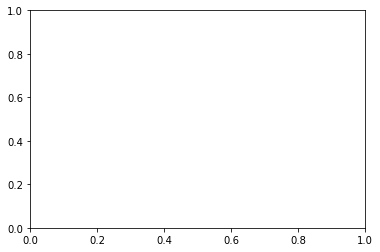

In [48]:
plt.plot(len(W[0]), W[0]*20)

In [27]:
naps_w

[<synapses_3.w: array([ 6.5510462 ,  0.34287333, -5.72263244, -2.75468694,  8.48645038,
        -7.07253608,  8.59317483,  6.72434846, -7.93574788, -7.70086994])>,
 <synapses_5.w: array([ 4.93609182, -2.8162177 , -8.1804243 , -3.14304484,  8.28429047,
        -7.24507592,  8.22519738,  6.69773689, -9.91920099, -7.36330797])>,
 <synapses_4.w: array([ -0.222341  ,  -9.23028118, -14.71490329,  -3.4956719 ,
          8.78791927,  -8.74212107,   7.79459104,   6.33664569,
        -17.21274776,  -8.2037113 ])>,
 <synapses_3.w: array([ -1.16399201, -11.40167053, -15.28588678,  -4.06184116,
          8.27328585, -10.02162628,   8.16659643,   5.47583015,
        -18.84867657,  -8.77539693])>,
 <synapses_5.w: array([ -1.64368825, -13.53928707, -16.25477438,  -4.13455656,
          7.91040934, -10.54037588,   8.29784214,   6.29164494,
        -19.84507694,  -8.62770402])>,
 <synapses_4.w: array([ -2.76609016, -18.03748648, -18.86727975,  -4.5719289 ,
          8.16063515, -10.54361209,   8.840557 

In [38]:
[W][0][0]*20

array([5.59890978, 3.18294414, 0.89475128, 0.3233948 , 0.3233948 ,
       0.89475128, 3.18294414, 5.59890978])